In [19]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

## Get data

In [20]:
with open('../forecast_pipeline/pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [21]:
data_fname = glob('../forecast_pipeline/pipeline_data/data_????-??-??.csv')[0]
df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')

In [22]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'urban_risk'
]
cov = '+'.join(covariates)

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,9.0,23.0,42.0,45.0,61.0,43.0,...,-0.149053,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,1.006875,0.666999
01003,29.0,37.0,43.0,38.0,34.0,35.0,38.0,19.0,10.0,21.0,...,0.349320,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.296454,0.817850
01005,2.0,7.0,9.0,14.0,11.0,15.0,21.0,26.0,45.0,40.0,...,-0.241908,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.420657,-0.240836
01007,4.0,9.0,13.0,8.0,8.0,3.0,5.0,8.0,14.0,5.0,...,-0.248733,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.436170,-0.249735
01009,10.0,2.0,8.0,11.0,9.0,4.0,1.0,4.0,12.0,9.0,...,-0.143225,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.617627,-0.724261


## Get GLM predictions

### Functions

In [23]:
def glm(df, targets, cov, verbose=False):
    
    """
    """
    
    cors, r2s, coef_dfs = [], [], []
    df_glm = pd.DataFrame(index=df.index)
    
    for i in range(len(targets)):
        cur = targets[i]
        formula = f'{cur}~{cov}'

        model = smf.glm(
            formula=formula,
            data=df,
            family=sm.families.Poisson(sm.families.links.log())
        ).fit()
        
        if verbose:
            print(f'{model.summary()}\n\n')

        prd = model.predict()
        df_glm[f'{cur}_glm'] = prd
        
        cor_cur = pd.DataFrame(
            data={'prd': prd, 'grd': df[cur].values}, 
            index=df.index).corr().loc['prd', 'grd']
        cors.append(cor_cur)
        r2s.append(r2_score(prd, df[cur].values))

        # Get and save coefficients
        results_as_html = model.summary().tables[1].as_html()
        summary = pd.read_html(results_as_html, header=0, index_col=0)[0] 
        coef_dfs.append(summary[['coef']].rename(columns={'coef': cur}))
    
    cor_df = pd.DataFrame(data={'cor': cors}, index=steps)
    r2_df = pd.DataFrame(data={'r2': r2s}, index=steps)
    
    coef_df = pd.concat(coef_dfs, axis=1).rename(columns={t: s for t, s in zip(targets, steps)}).T
    coef_df.index.name = 'date'
    
    return cor_df, r2_df, coef_df, df_glm

In [24]:
states = {
    'NY': '36', 
    'CA': '06', 
    'TX': '48', 
    'FL': '12'
}

# cov = 'perc_urban_pop+risk_flu+urban_risk'
cov = '+'.join(covariates)
xtl = ['-'.join(date.split('-')[1:]) for date in steps]

/usr/local/lib64/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib64/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib64/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib64/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib64/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib64/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter s

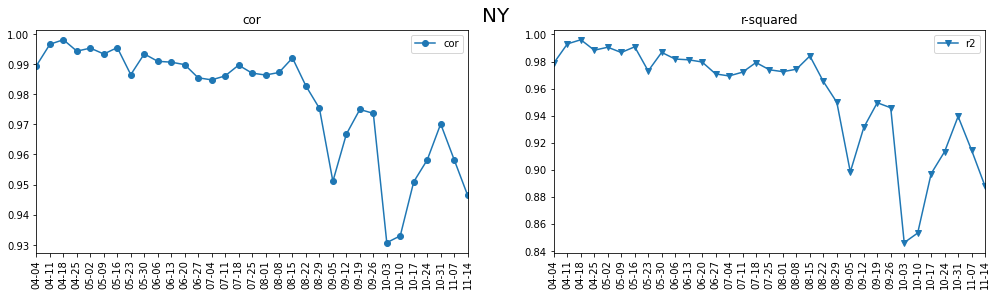

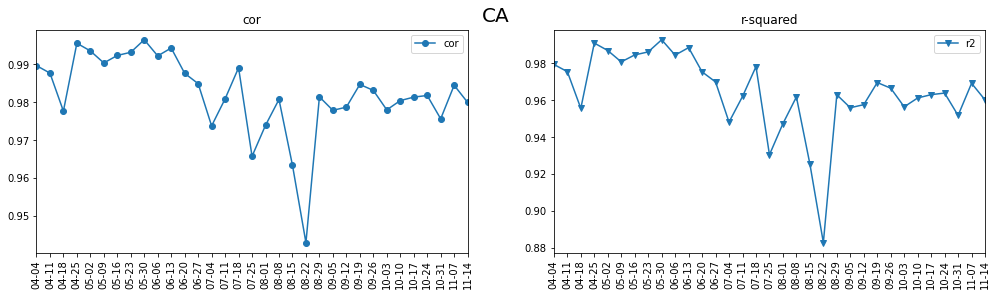

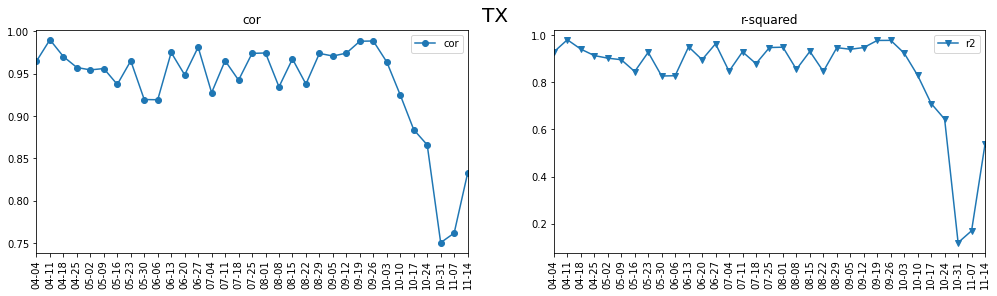

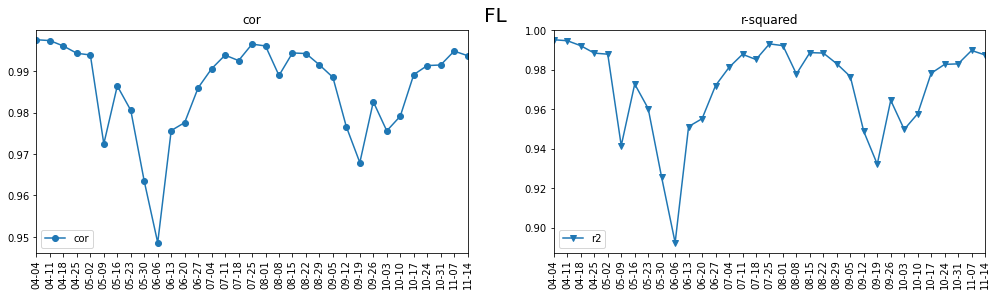

In [25]:
# dfs = []
for s in states:
    indices = [idx for idx in df_z.index if idx.startswith(states[s])]
    cor_df, r2_df, coef_df, df_glm = glm(df_z.loc[indices], steps_c, cov)
    df_forecast = df_z.loc[indices][steps_c].join(df_glm)
    df_forecast.to_csv(f'results/case_full_{s}.csv', float_format='%.2f')
    
    # df = pd.concat([coef_df, cor_df, r2_df], axis=1)
    # df['state'] = s
    # dfs.append(df)

    fig, axes = plt.subplots(1, 2, figsize=(17, 4))
    fig.subplots_adjust(top=.9)
    
    ax = axes[0]
    cor_df.plot(ax=ax, marker='o')
    ax.set_title('cor')
    ax.set_xticks(range(len(steps)))
    ax.set_xticklabels(xtl)
    ax.tick_params(axis='x', rotation=90)
    
    ax = axes[1]
    r2_df.plot(ax=ax, marker='v')
    ax.set_title('r-squared')
    ax.set_xticks(range(len(steps)))
    ax.set_xticklabels(xtl)
    ax.tick_params(axis='x', rotation=90)
    
    fig.suptitle(s, fontsize=20)

# pd.concat(dfs).to_csv('results/fourStates_slim_case.csv', float_format='%.5f')